## Install the package dependencies before running this notebook

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import os, os.path 
import numpy 
import pickle
from glob import glob
import itertools

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

## Create a Torch.Dataset class for the training dataset

In [2]:
from glob import glob
import pickle5 as pickle
import numpy as np

ROOT_PATH = "./argo2/"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "validation", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):
    if split=="train" or split=="validation":
        if city == "all":
            inputs = None
            outputs = None
            for c in cities:
                f_in = ROOT_PATH + "train" + "/" + c + "_inputs"
                i = pickle.load(open(f_in, "rb"))
                i = np.asarray(i)
                inputs = i if inputs is None else np.concatenate((inputs,i))
                f_out = ROOT_PATH + "train" + "/" + c + "_outputs"
                o = pickle.load(open(f_out, "rb"))
                o = np.asarray(o)
                outputs = o if outputs is None else np.concatenate((outputs,o))

        else:
            f_in = ROOT_PATH + "train" + "/" + city + "_inputs"
            inputs = pickle.load(open(f_in, "rb"))
            inputs = np.asarray(inputs)
            f_out = ROOT_PATH + "train" + "/" + city + "_outputs"
            outputs = pickle.load(open(f_out, "rb"))
            outputs = np.asarray(outputs)
        
        
        if split == "train":
            inputs = inputs[:inputs.shape[0]*4//5]
        else:
            inputs = inputs[inputs.shape[0]*4//5:]
    
        if split == "train":
            outputs = outputs[:outputs.shape[0]*4//5]
        else:
            outputs = outputs[outputs.shape[0]*4//5:]
    else:
        f_in = ROOT_PATH + "test" + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        inputs = np.asarray(inputs)
        outputs = None

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform 
        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)
        else:
            #normalize start pos
            inp = self.inputs[idx]-data[0][0]
            out = self.outputs[idx]-data[0][0]
            data = (inp, out)

        return data
    
#     def split(self, split_ratio=0.2):
#         valid_size = round(split_ratio * len(self.inputs))
#         train_size = len(self.inputs) - valid_size

#         return random_split(self, [train_size, valid_size])

def transform(data):
    # currently 109 input - 109 out
    inp = np.concatenate((data[0], data[1][:-1]))
    out = np.concatenate((data[0][1:], data[1]))

    #normalize start pos
    inp -= data[0][0]
    out -= data[0][0]
    return (inp, out)

def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1])
        axs[i].scatter(out[i,:,0], out[i,:,1])


# Data Analysis

In [3]:
import matplotlib.pyplot as plt
def dummy_transform(data):
    return data
train_datasets = [ArgoverseDataset(city, "train", dummy_transform) for city in cities]
val_datasets = [ArgoverseDataset(city, "validation", dummy_transform) for city in cities]
test_datasets = [ArgoverseDataset(city, "test", dummy_transform) for city in cities]

print("Dataset Sizes:")
train_size_string = "\t Training: "
train_total = 0
val_size_string = "\t Validation: "
val_total = 0
test_size_string = "\t Test: "
test_total = 0
for i, city in enumerate(cities):
    train_size_string += city+"- "+str(len(train_datasets[i]))+", "
    train_total += len(train_datasets[i])
    val_size_string += city+"- "+str(len(val_datasets[i]))+", "
    val_total += len(val_datasets[i])
    test_size_string += city+"- "+str(len(test_datasets[i]))+", "
    test_total += len(test_datasets[i])
train_size_string += "total- "+str(train_total)
val_size_string += "total- "+str(val_total)
test_size_string += "total- "+str(test_total)
print(train_size_string)
print(val_size_string)
print(test_size_string)
print()

print("Data Dimensions: input- %s, output- %s" % \
      (str(train_datasets[0][0][0].shape), str(train_datasets[0][0][1].shape)))
print()

Dataset Sizes:
	 Training: austin- 34432, miami- 44023, pittsburgh- 34835, dearborn- 19572, washington-dc- 20595, palo-alto- 9594, total- 163051
	 Validation: austin- 8609, miami- 11006, pittsburgh- 8709, dearborn- 4893, washington-dc- 5149, palo-alto- 2399, total- 40765
	 Test: austin- 6325, miami- 7971, pittsburgh- 6361, dearborn- 3671, washington-dc- 3829, palo-alto- 1686, total- 29843

Data Dimensions: input- (50, 2), output- (60, 2)



------------------------------------GLOBAL POSITION HEATMAPS--------------------------------------


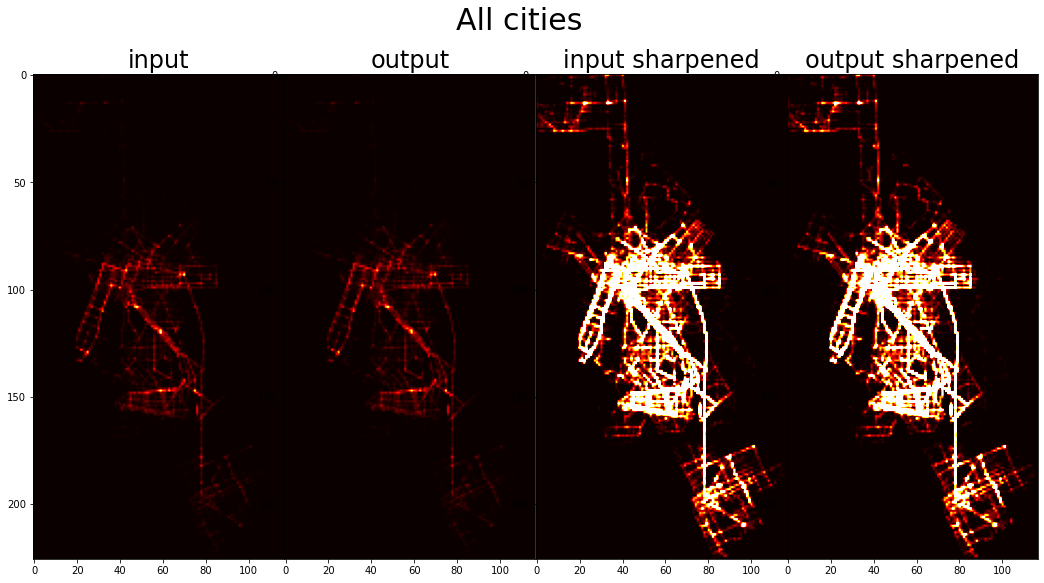

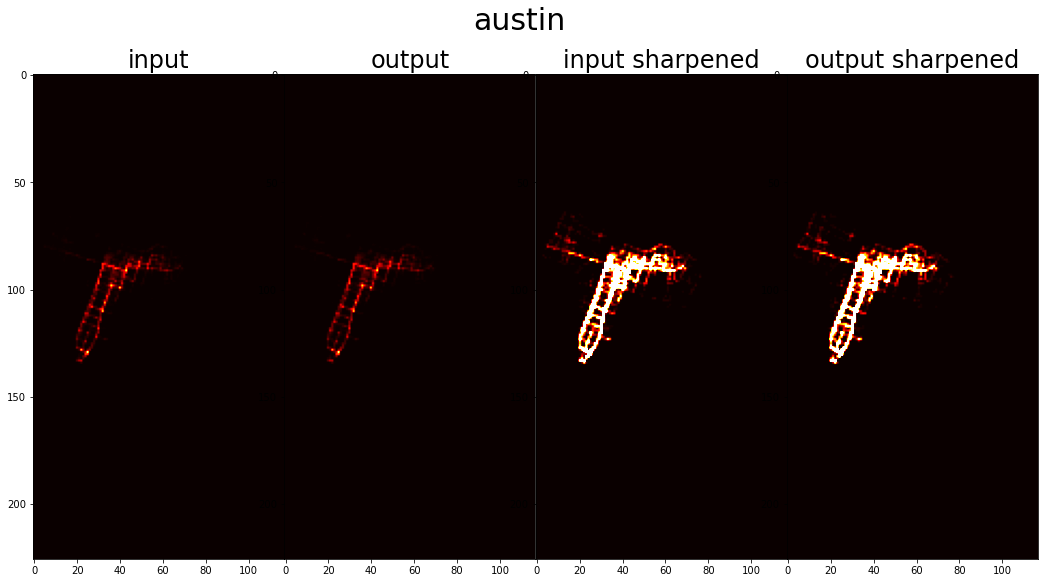

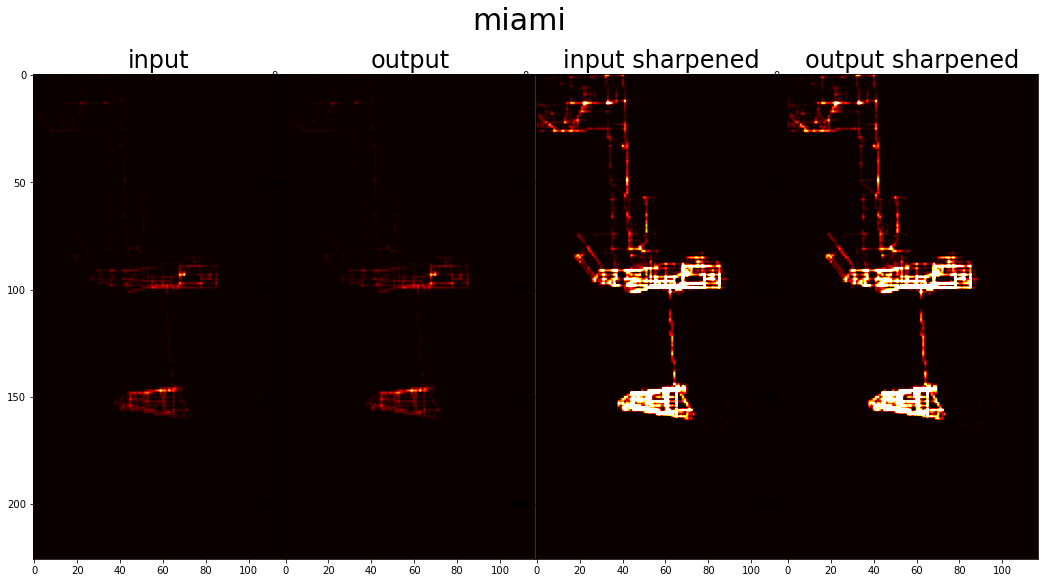

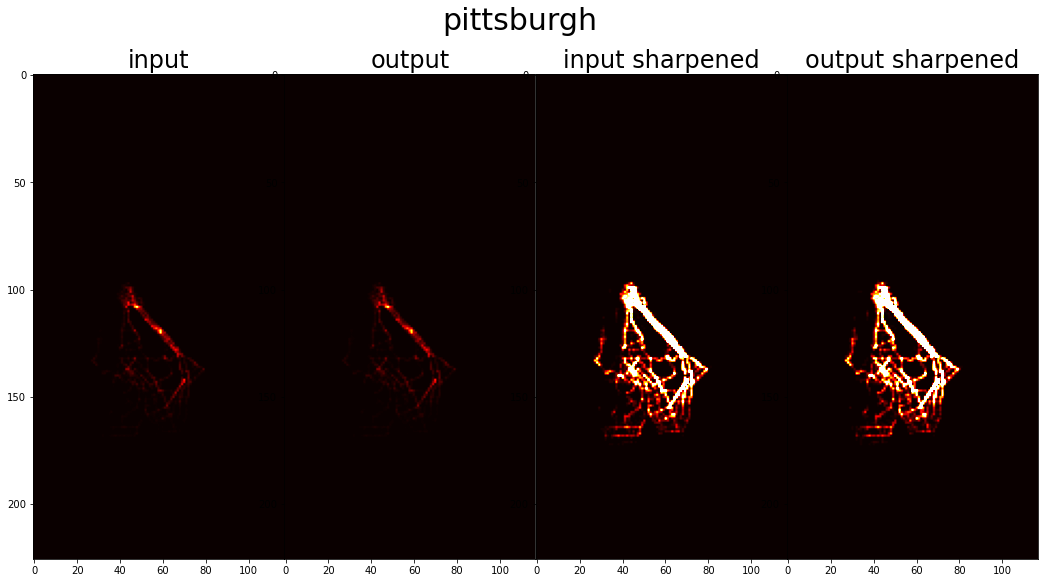

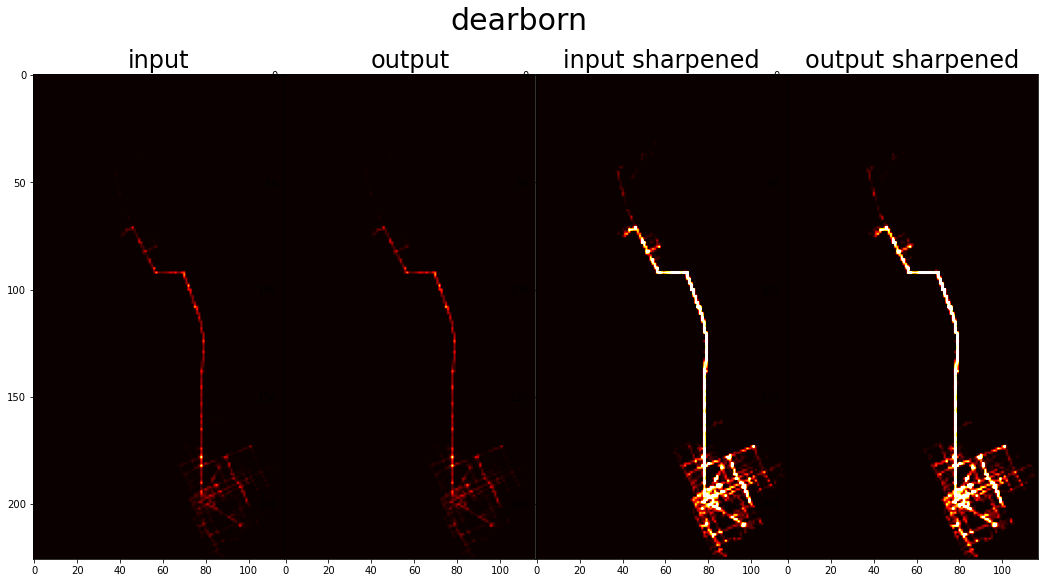

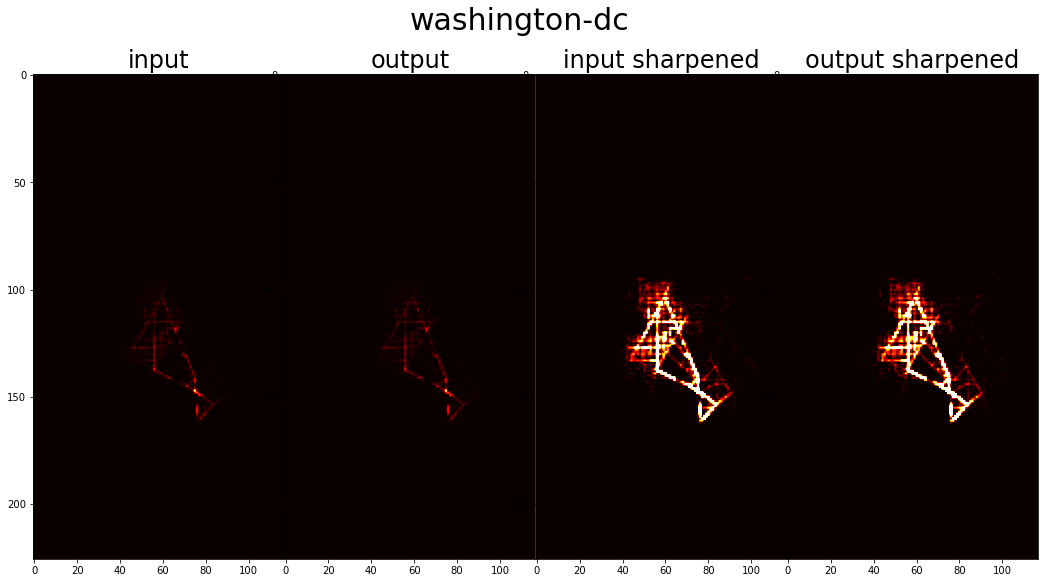

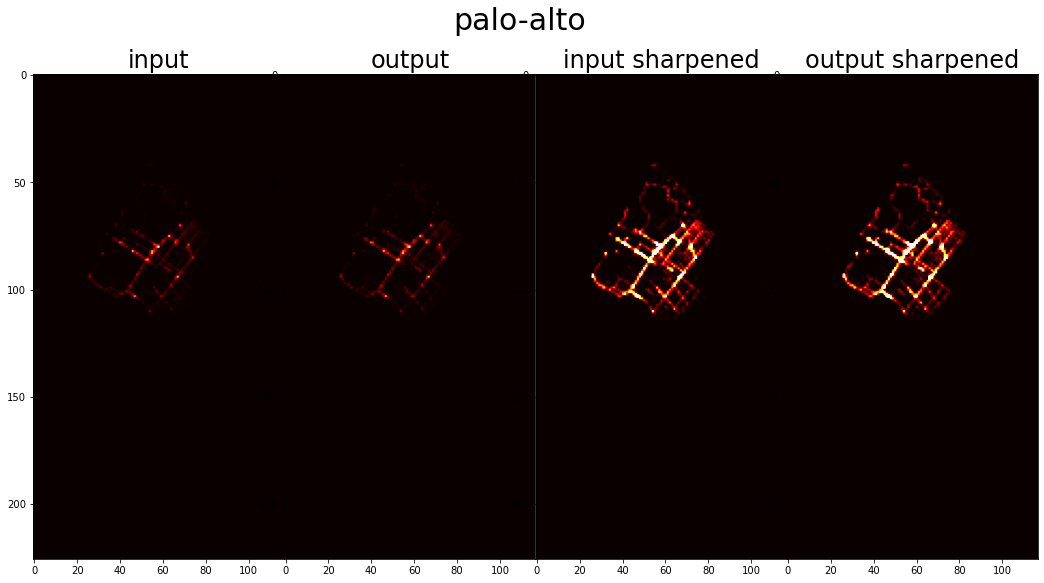

In [5]:
# Get heatmap bounds
max_x = float("-inf")
min_x = float("inf")
max_y = float("-inf")
min_y = float("inf")

max_xn = float("-inf")
min_xn = float("inf")
max_yn = float("-inf")
min_yn = float("inf")
for datasets in [train_datasets, val_datasets]:
    for dataset in datasets:
        for i in range(len(dataset)):
            inp, out = dataset[i]
            max_x = max([max_x, np.max(inp[:, 0]), np.max(out[:, 0])])
            min_x = min([min_x, np.min(inp[:, 0]), np.min(out[:, 0])])
            max_y = max([max_y, np.max(inp[:, 1]), np.max(out[:, 1])])
            min_y = min([min_y, np.min(inp[:, 1]), np.min(out[:, 1])])
            
            inpn, outn = inp-inp[0], out-inp[0]
            max_xn = max([max_xn, np.max(inpn[:, 0]), np.max(outn[:, 0])])
            min_xn = min([min_xn, np.min(inpn[:, 0]), np.min(outn[:, 0])])
            max_yn = max([max_yn, np.max(inpn[:, 1]), np.max(outn[:, 1])])
            min_yn = min([min_yn, np.min(inpn[:, 1]), np.min(outn[:, 1])])
max_x, min_x, max_y, min_y = int(max_x)+1, int(min_x)-1, int(max_y)+1, int(min_y)-1
max_xn, min_xn, max_yn, min_yn = int(max_xn)+1, int(min_xn)-1, int(max_yn)+1, int(min_yn)-1

# Generate heatmaps for training data
factor = 100
# group together non-normed positions into factorXfactor chunks in order to generate more informative heat map
inp_heatmap_list = [np.zeros((int(max_x - min_x)//factor+1, int(max_y - min_y)//factor+1)) \
                   for _ in datasets]
out_heatmap_list = [np.zeros((int(max_x - min_x)//factor+1, int(max_y - min_y)//factor+1)) \
                   for _ in datasets]

inpn_heatmap_list = [np.zeros((max_xn - min_xn + 1, max_yn - min_yn + 1)) \
                   for _ in datasets]
outn_heatmap_list = [np.zeros((max_xn - min_xn + 1, max_yn - min_yn + 1)) \
                   for _ in datasets]
for datasets in [train_datasets, val_datasets]:
    for dataset, inp_heatmap, out_heatmap, inpn_heatmap, outn_heatmap in \
        zip(datasets, inp_heatmap_list, out_heatmap_list, inpn_heatmap_list, outn_heatmap_list):
        for i in range(len(dataset)):
            inp, out = dataset[i]
            inp, out = np.rint(inp).astype(int), np.rint(out).astype(int)
            inp_heatmap[(inp[:, 0] - min_x)//factor, (inp[:, 1] - min_y)//factor] += 1
            out_heatmap[(out[:, 0] - min_x)//factor, (out[:, 1] - min_y)//factor] += 1
            
            inpn, outn = (inp-inp[0]).astype(int), (out-inp[0]).astype(int)
            inpn_heatmap[inpn[:, 0] - min_xn, inpn[:, 1] - min_yn] += 1
            outn_heatmap[outn[:, 0] - min_xn, outn[:, 1] - min_yn] += 1

# Get and display combined heatmap
print("------------------------------------GLOBAL POSITION HEATMAPS--------------------------------------")
fig, axs = plt.subplots(1,4, figsize=(18, 9), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
fig.suptitle("All cities", fontsize=30)
inp_heatmap = sum(inp_heatmap_list)
out_heatmap = sum(out_heatmap_list)
axs[0].set_title("input", fontsize=24)
axs[0].imshow(inp_heatmap, cmap="hot")
axs[1].set_title("output", fontsize=24)
axs[1].imshow(out_heatmap, cmap="hot")
# add a ceiling to the maximum value to generate "sharpened" heat map 
sharpener = 50
axs[2].set_title("input sharpened", fontsize=24)
axs[2].imshow(inp_heatmap, vmax=sharpener, cmap="hot")
axs[3].set_title("output sharpened", fontsize=24)
axs[3].imshow(out_heatmap, vmax=sharpener, cmap="hot")

# display heatmap for each city
for i, name in enumerate(cities):
    fig, axs = plt.subplots(1,4, figsize=(18, 9), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    fig.suptitle(name, fontsize=30)
    axs[0].set_title("input", fontsize=24)
    axs[0].imshow(inp_heatmap_list[i], cmap="hot")
    axs[1].set_title("output", fontsize=24)
    axs[1].imshow(out_heatmap_list[i], cmap="hot")
    axs[2].set_title("input sharpened", fontsize=24)
    axs[2].imshow(inp_heatmap_list[i], vmax = sharpener, cmap="hot")
    axs[3].set_title("output sharpened", fontsize=24)
    axs[3].imshow(out_heatmap_list[i], vmax=sharpener, cmap="hot")
    

------------------------------------LOCAL POSITION HEATMAPS--------------------------------------


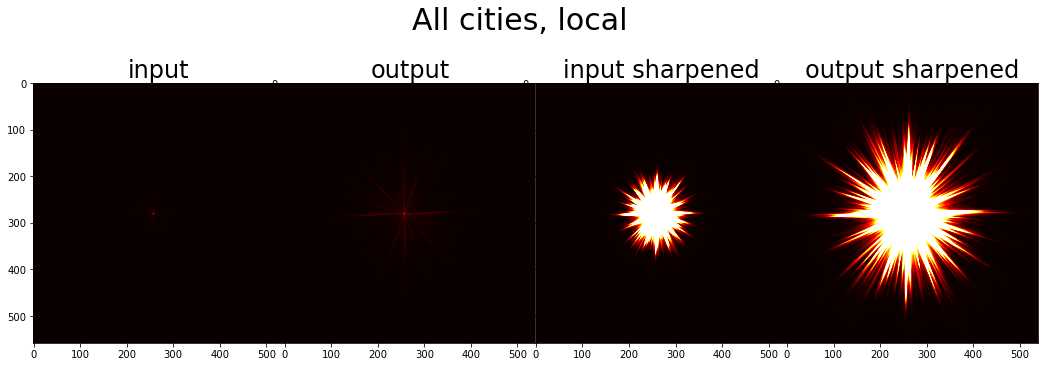

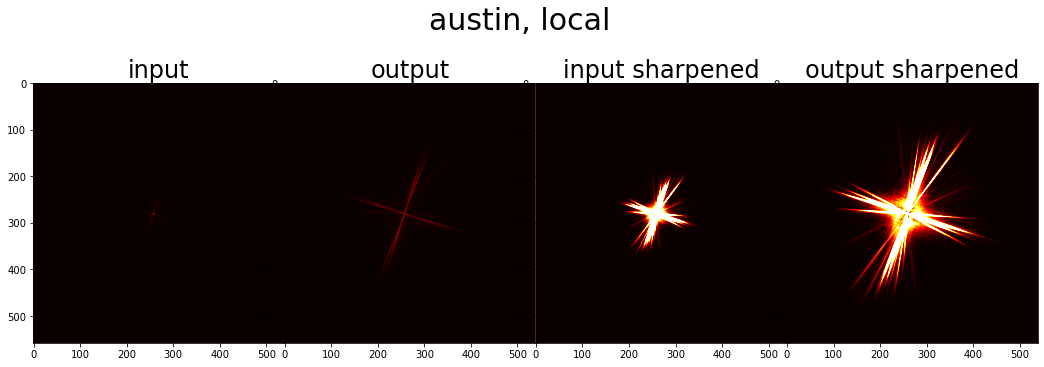

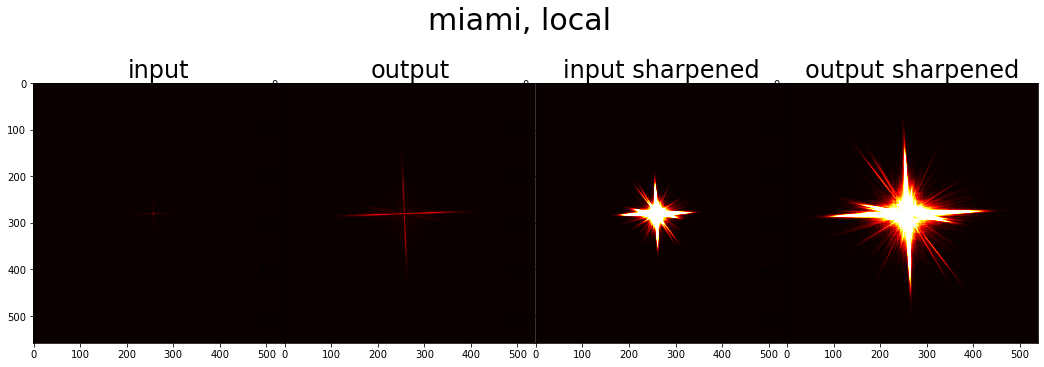

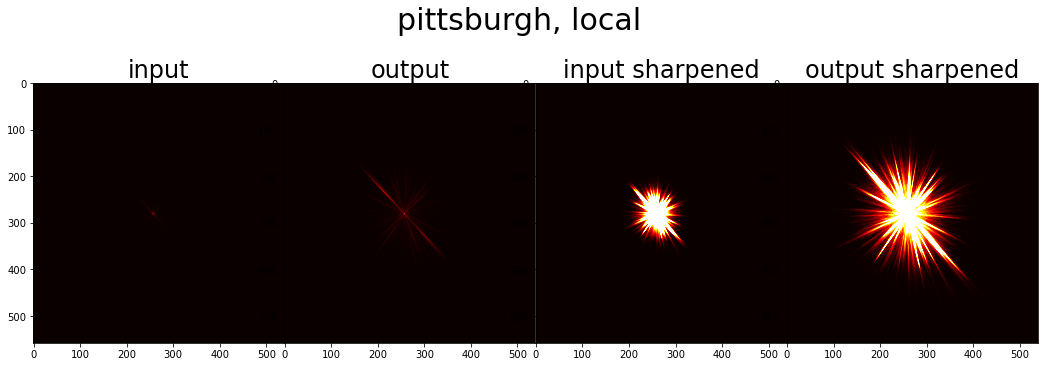

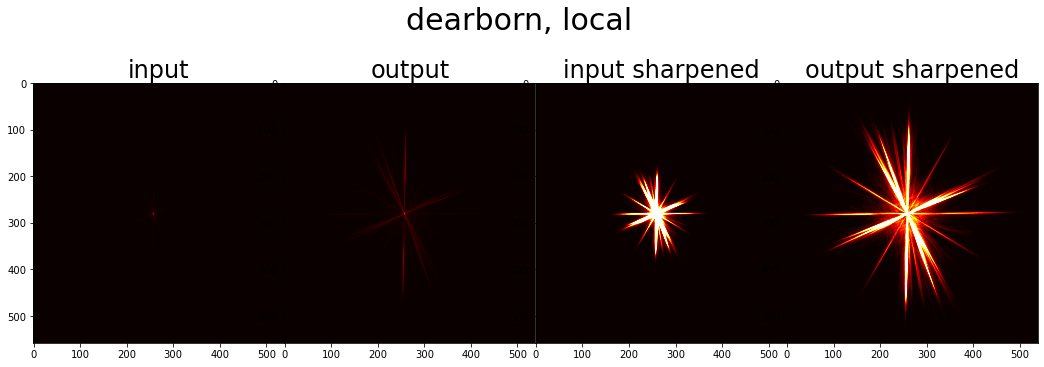

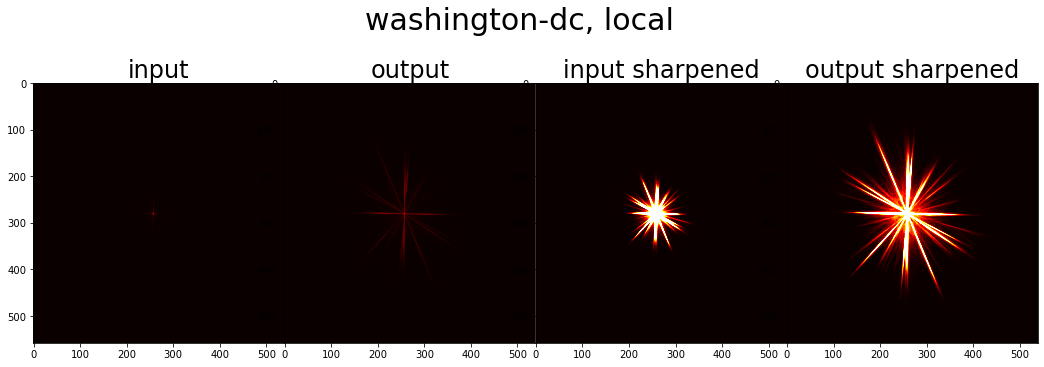

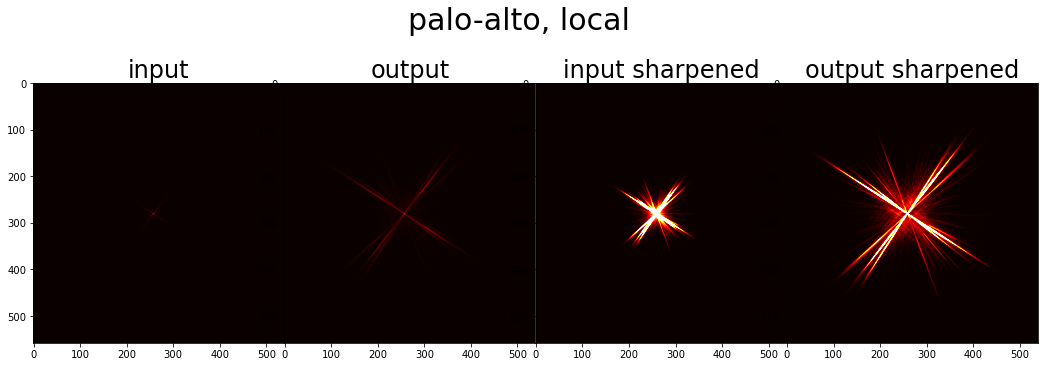

In [10]:
# Get and display combined heatmap
print("------------------------------------LOCAL POSITION HEATMAPS--------------------------------------")
fig, axs = plt.subplots(1,4, figsize=(18, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
fig.suptitle("All cities, local", fontsize=30)
inpn_heatmap = sum(inpn_heatmap_list)
outn_heatmap = sum(outn_heatmap_list)
axs[0].set_title("input", fontsize=24)
axs[0].imshow(inpn_heatmap, cmap="hot")
axs[1].set_title("output", fontsize=24)
axs[1].imshow(outn_heatmap, cmap="hot")
# add a ceiling to the maximum value to generate "sharpened" heat map 
sharpener = 50
axs[2].set_title("input sharpened", fontsize=24)
axs[2].imshow(inpn_heatmap, vmax=sharpener, cmap="hot")
axs[3].set_title("output sharpened", fontsize=24)
axs[3].imshow(outn_heatmap, vmax=sharpener, cmap="hot")

# display heatmap for each city
for i, name in enumerate(cities):
    fig, axs = plt.subplots(1,4, figsize=(18, 6), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    fig.suptitle(name + ", local", fontsize=30)
    axs[0].set_title("input", fontsize=24)
    axs[0].imshow(inpn_heatmap_list[i], cmap="hot")
    axs[1].set_title("output", fontsize=24)
    axs[1].imshow(outn_heatmap_list[i], cmap="hot")
    axs[2].set_title("input sharpened", fontsize=24)
    axs[2].imshow(inpn_heatmap_list[i], vmax = sharpener, cmap="hot")
    axs[3].set_title("output sharpened", fontsize=24)
    axs[3].imshow(outn_heatmap_list[i], vmax=sharpener, cmap="hot")

------------------------------------VELOCITY HISTOGRAMS--------------------------------------


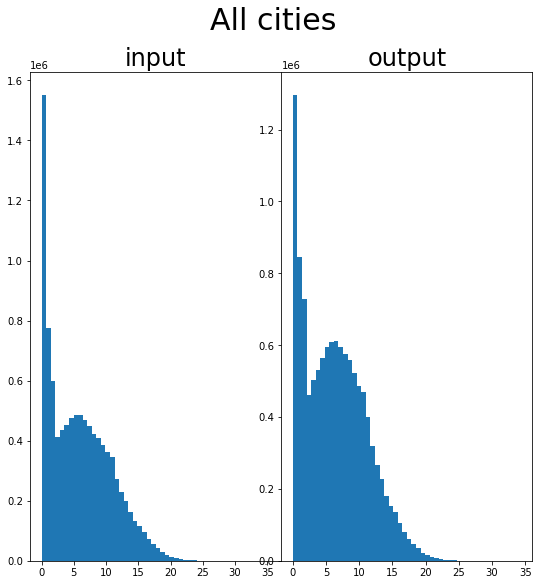

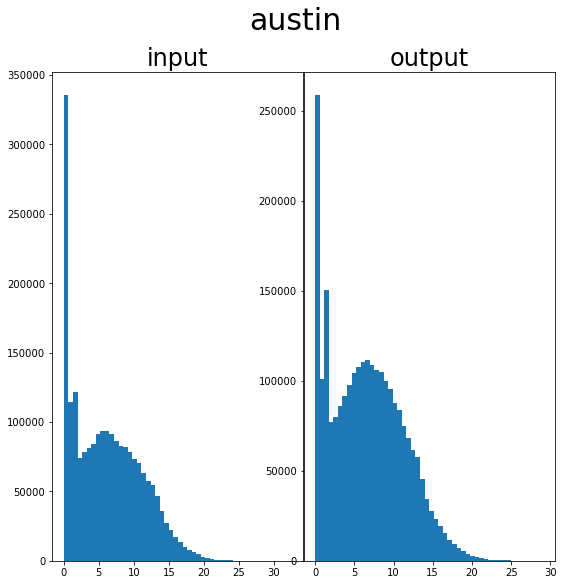

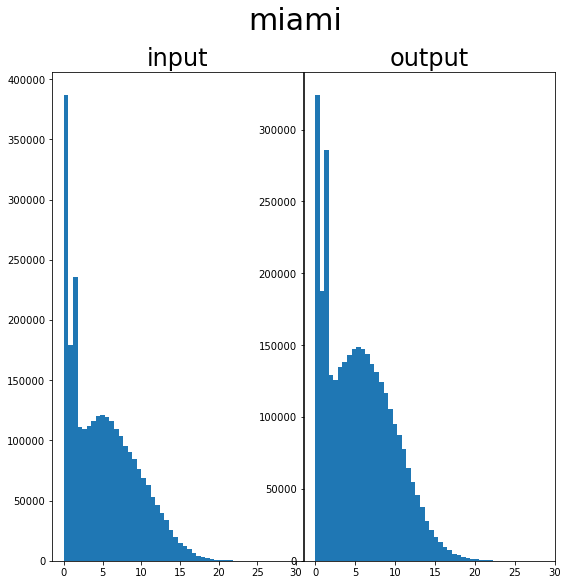

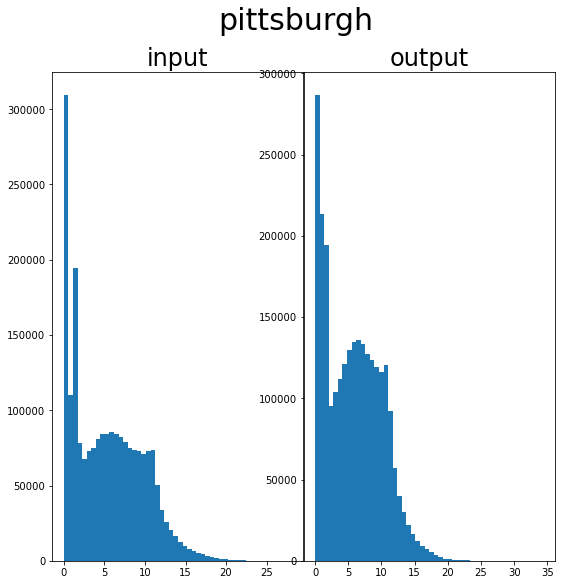

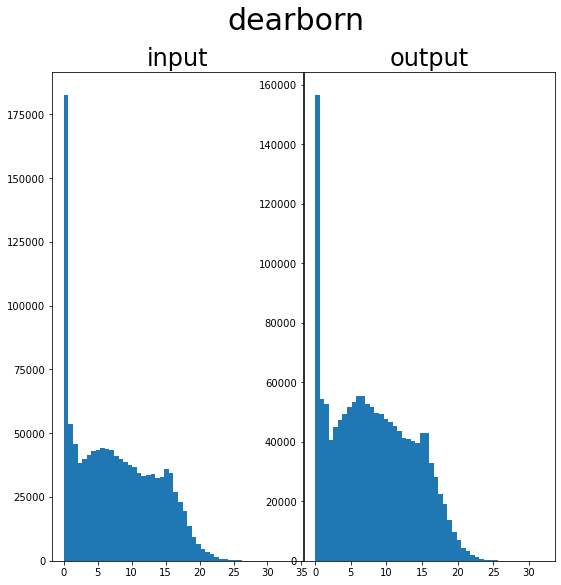

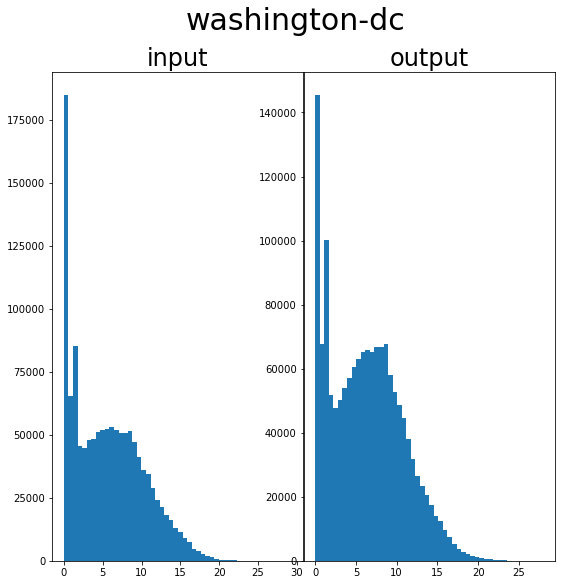

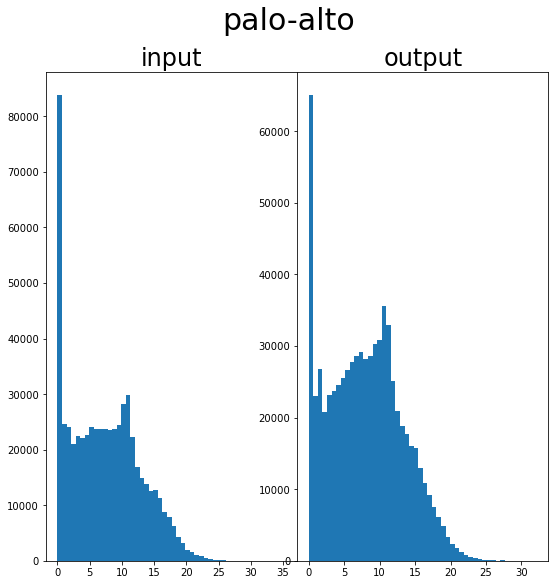

In [12]:
inp_speeds_list = [[] for _ in datasets]
out_speeds_list = [[] for _ in datasets]
for datasets in [train_datasets, val_datasets]:
    for dataset, inp_speeds, out_speeds in zip(datasets, inp_speeds_list, out_speeds_list):
        for i in range(len(dataset)):
            inp, out = dataset[i]
            inp_s = np.linalg.norm(inp[1:] - inp[:-1], axis=1)*10
            out_s = np.linalg.norm(out[1:] - out[:-1], axis=1)*10
            for speed in inp_s:
                inp_speeds.append(speed)
            for speed in out_s:
                out_speeds.append(speed)

print("------------------------------------VELOCITY HISTOGRAMS--------------------------------------")
fig, axs = plt.subplots(1,2, figsize=(9, 9), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
fig.suptitle("All cities", fontsize=30)
inp_speeds = list(itertools.chain(*inp_speeds_list))
out_speeds = list(itertools.chain(*out_speeds_list))
bins = 50
axs[0].set_title("input", fontsize=24)
axs[0].hist(inp_speeds, bins=bins)
axs[1].set_title("output", fontsize=24)
axs[1].hist(out_speeds, bins=bins)

for i, name in enumerate(cities):
    fig, axs = plt.subplots(1,2, figsize=(9, 9), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    fig.suptitle(name, fontsize=30)
    axs[0].set_title("input", fontsize=24)
    axs[0].hist(inp_speeds_list[i], bins=bins)
    axs[1].set_title("output", fontsize=24)
    axs[1].hist(out_speeds_list[i], bins=bins)

------------------------------------ACCELERATION HISTOGRAMS--------------------------------------


(0.0, 100000.0)

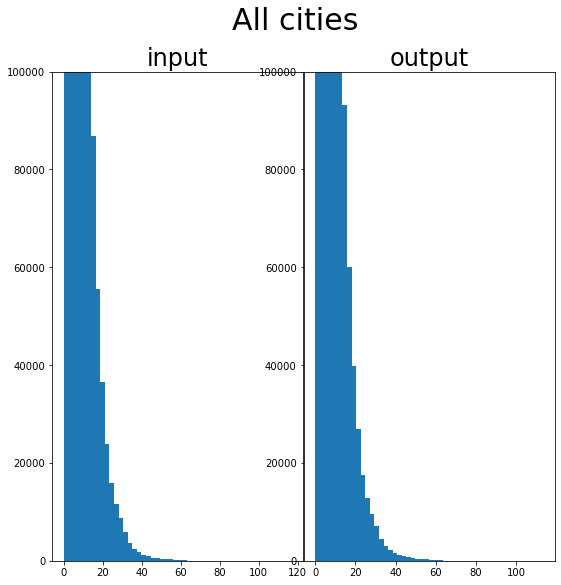

In [9]:
inp_accels_list = [[] for _ in datasets]
out_accels_list = [[] for _ in datasets]
for datasets in [train_datasets, val_datasets]:
    for dataset, inp_accels, out_accels in zip(datasets, inp_accels_list, out_accels_list):
        for i in range(len(dataset)):
            inp, out = dataset[i]
            inp_s = (inp[1:] - inp[:-1])
            out_s = (out[1:] - out[:-1])
            inp_a = np.linalg.norm(inp_s[1:] - inp_s[:-1], axis=1)*100
            out_a = np.linalg.norm(out_s[1:] - out_s[:-1], axis=1)*100
            for accel in inp_a:
                inp_accels.append(accel)
            for accel in out_a:
                out_accels.append(accel)

print("------------------------------------ACCELERATION HISTOGRAMS--------------------------------------")
fig, axs = plt.subplots(1,2, figsize=(9, 9), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
fig.suptitle("All cities", fontsize=30)
inp_accels = list(itertools.chain(*inp_accels_list))
out_accels = list(itertools.chain(*out_accels_list))
bins = 50
axs[0].set_title("input", fontsize=24)
axs[0].hist(inp_accels, bins=bins)
axs[0].set_ylim([0,1e5])
axs[1].set_title("output", fontsize=24)
axs[1].hist(out_accels, bins=bins)
axs[1].set_ylim([0,1e5])

# for i, name in enumerate(cities):
#     fig, axs = plt.subplots(1,2, figsize=(9, 9), facecolor='w', edgecolor='k')
#     fig.subplots_adjust(hspace = .5, wspace=.001)
#     fig.suptitle(name, fontsize=30)
#     axs[0].set_title("input", fontsize=24)
#     axs[0].hist(inp_accels_list[i], bins=bins)
#     axs[1].set_title("output", fontsize=24)
#     axs[1].hist(out_accels_list[i], bins=bins)

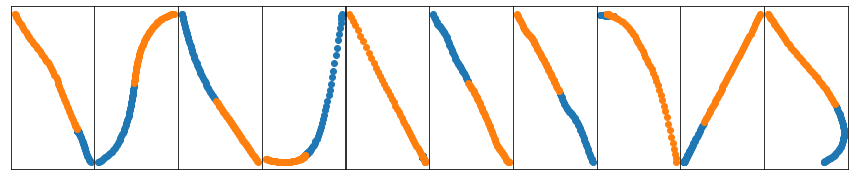

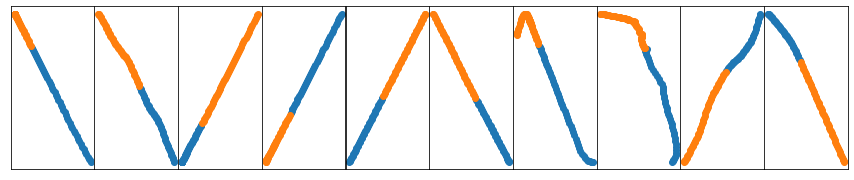

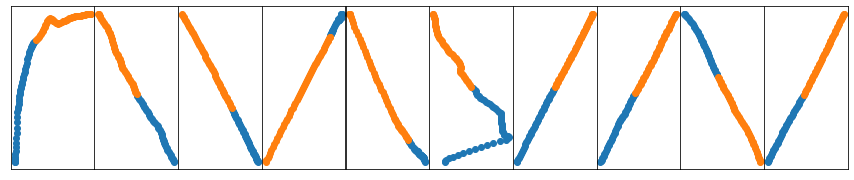

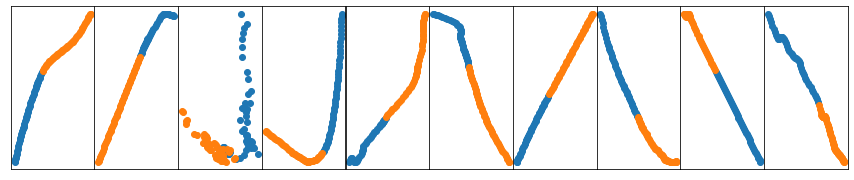

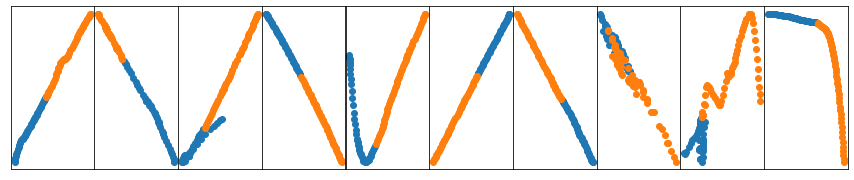

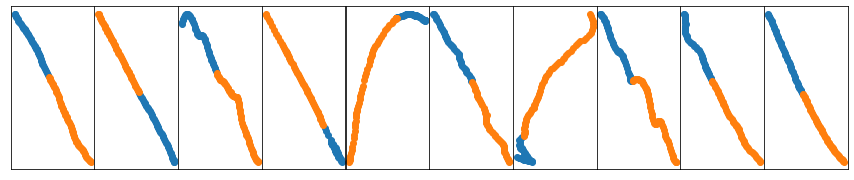

In [33]:
train_dataset = ArgoverseDataset(city = "all", split = "train")
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
threshs = [0, 10, 20, 30, 40, 50, 60]#, 80, 100]
counts = torch.zeros(len(threshs)-1, dtype=int)
total_x = torch.zeros((len(threshs)-1, 10, 50, 2))
total_y = torch.zeros((len(threshs)-1, 10, 60, 2))
while (counts < 10).any():
    x, y = next(iter(train_loader))
#     x_l = torch.sum(torch.linalg.norm(x[:, 1:] - x[:, :-1], dim=2)[0])
#     y_l = torch.sum(torch.linalg.norm(y[:, 1:] - y[:, :-1], dim=2)[0])
#     mid_l = torch.linalg.norm(y[:, 0] - x[:, -1], dim=1)[0]
#     p_len = x_l + y_l + mid_l
    x_v = (x[:, 1:] - x[:, :-1])
    y_v = (y[:, 1:] - y[:, :-1])
    x_a = torch.max(torch.linalg.norm(x_v[:, 1:] - x_v[:, :-1], axis=2)*100, dim=1)[0]
    y_a = torch.max(torch.linalg.norm(y_v[:, 1:] - y_v[:, :-1], axis=2)*100, dim=1)[0]
    a = (x_a + y_a)/2
    idx = 0
    while idx < len(threshs)-2 and a > threshs[idx+1]:
        idx += 1
    if counts[idx] < 10:
        total_x[idx, counts[idx]:counts[idx]+1] += x
        total_y[idx, counts[idx]:counts[idx]+1] += y
        counts[idx] += 1
# for i, (low, high) in enumerate(zip(threshs[:-1], threshs[1:])):
#     count = 0
#     while count < 10:
#         x, y = next(iter(train_loader))
#         x_l = torch.sum(torch.linalg.norm(x[:, 1:] - x[:, :-1], dim=2)[0])
#         y_l = torch.sum(torch.linalg.norm(y[:, 1:] - y[:, :-1], dim=2)[0])
#         mid_l = torch.linalg.norm(y[:, 0] - x[:, -1], dim=1)[0]
#         p_len = x_l + y_l + mid_l
#         if p_len >= low and p_len < high:
#             total_x[i, count:count+1] += x
#             total_y[i, count:count+1] += y
#             count += 1
for i in range(total_x.size(0)):
    show_sample_batch((total_x[i], total_y[i]))
plt.show()

## Path Length

------------------------------------LENGTH HISTOGRAMS--------------------------------------


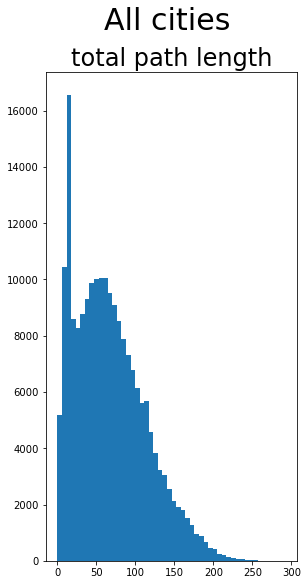

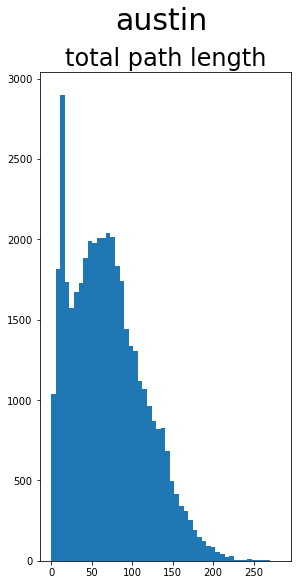

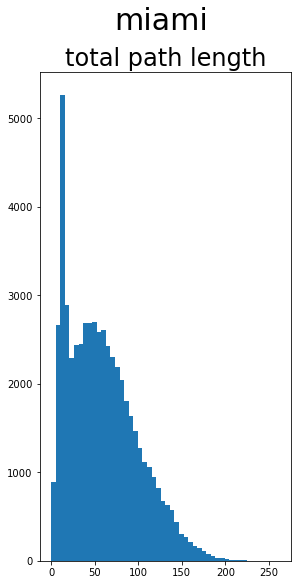

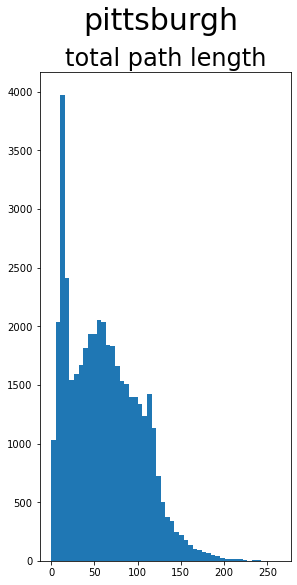

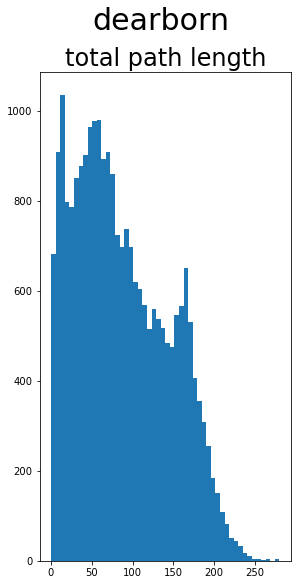

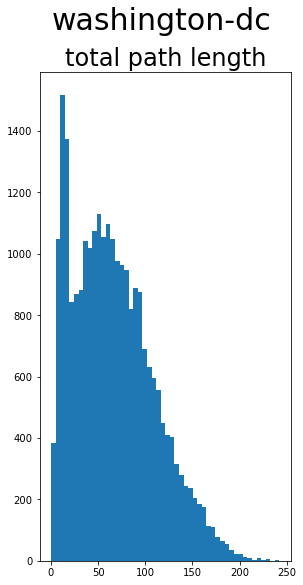

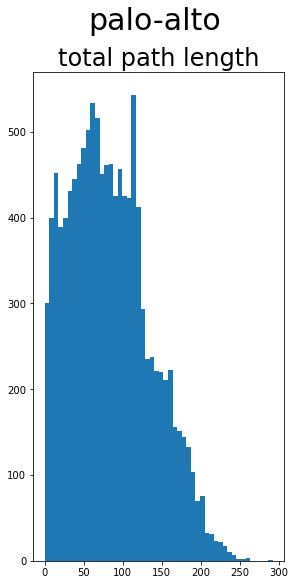

In [9]:
lens_list = [[] for _ in datasets]
for datasets in [train_datasets, val_datasets]:
    for dataset, lens in zip(datasets, lens_list):
        for i in range(len(dataset)):
            inp, out = dataset[i]
            inp_l = np.sum(np.linalg.norm(inp[1:] - inp[:-1], axis=1))
            out_l = np.sum(np.linalg.norm(out[1:] - out[:-1], axis=1))
            mid_l = np.linalg.norm(out[0] - inp[-1])
            lens.append(inp_l + out_l + mid_l)

print("------------------------------------LENGTH HISTOGRAMS--------------------------------------")
fig, axs = plt.subplots(1,1, figsize=(4.5, 9), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
fig.suptitle("All cities", fontsize=30)
lens = list(itertools.chain(*lens_list))
# out_speeds = list(itertools.chain(*out_speeds_list))
bins = 50
axs.set_title("total path length", fontsize=24)
axs.hist(lens, bins=bins)
# axs[1].set_title("output", fontsize=24)
# axs[1].hist(out_speeds, bins=bins)

for i, name in enumerate(cities):
    fig, axs = plt.subplots(1,1, figsize=(4.5, 9), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    fig.suptitle(name, fontsize=30)
    axs.set_title("total path length", fontsize=24)
    axs.hist(lens_list[i], bins=bins)
#     axs[1].set_title("output", fontsize=24)
#     axs[1].hist(out_speeds_list[i], bins=bins)

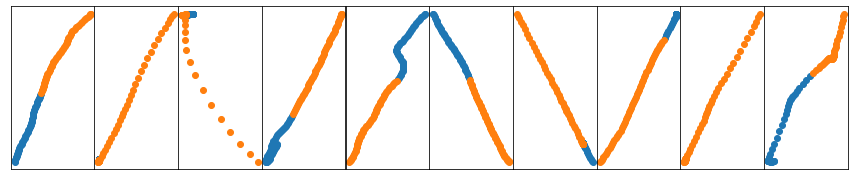

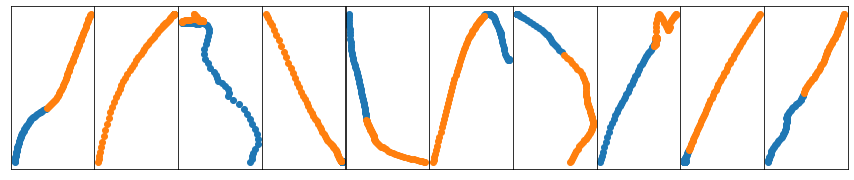

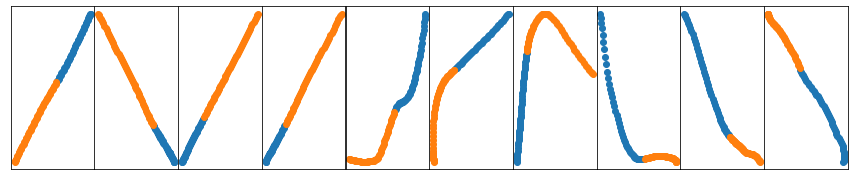

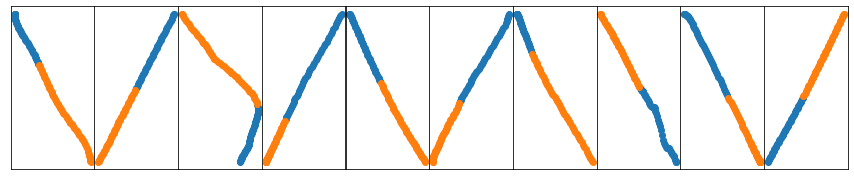

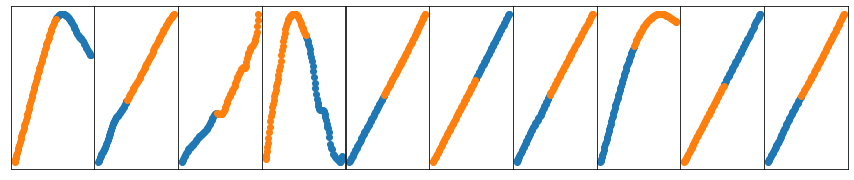

In [26]:
train_dataset = ArgoverseDataset(city = "all", split = "train")
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
threshs = [0, 15, 40, 80, 150, 300]
counts = torch.zeros(len(threshs)-1, dtype=int)
total_x = torch.zeros((len(threshs)-1, 10, 50, 2))
total_y = torch.zeros((len(threshs)-1, 10, 60, 2))
while (counts < 10).any():
    x, y = next(iter(train_loader))
    x_l = torch.sum(torch.linalg.norm(x[:, 1:] - x[:, :-1], dim=2)[0])
    y_l = torch.sum(torch.linalg.norm(y[:, 1:] - y[:, :-1], dim=2)[0])
    mid_l = torch.linalg.norm(y[:, 0] - x[:, -1], dim=1)[0]
    p_len = x_l + y_l + mid_l
    idx = 0
    while idx < len(threshs)-1 and p_len > threshs[idx+1]:
        idx += 1
    if counts[idx] < 10:
        total_x[idx, counts[idx]:counts[idx]+1] += x
        total_y[idx, counts[idx]:counts[idx]+1] += y
        counts[idx] += 1
# for i, (low, high) in enumerate(zip(threshs[:-1], threshs[1:])):
#     count = 0
#     while count < 10:
#         x, y = next(iter(train_loader))
#         x_l = torch.sum(torch.linalg.norm(x[:, 1:] - x[:, :-1], dim=2)[0])
#         y_l = torch.sum(torch.linalg.norm(y[:, 1:] - y[:, :-1], dim=2)[0])
#         mid_l = torch.linalg.norm(y[:, 0] - x[:, -1], dim=1)[0]
#         p_len = x_l + y_l + mid_l
#         if p_len >= low and p_len < high:
#             total_x[i, count:count+1] += x
#             total_y[i, count:count+1] += y
#             count += 1
for i in range(total_x.size(0)):
    show_sample_batch((total_x[i], total_y[i]))
plt.show()